In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm 
from glob import glob
from skimage.io import imread
from skimage.measure import label, regionprops_table
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def print_evaluate(true, predicted):  
    
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def run_all_regressions(X_train, X_test, Y_train, Y_test, regs):

    for name, model in regs.items():

        model.fit(X_train, Y_train)
        
        print(f'\n-----{name}------')
        print('[Train] -------------')
        print_evaluate(Y_train, model.predict(X_train))

        print('[Test] --------------')
        print_evaluate(Y_test, model.predict(X_test))
        
def extract_props_from_image(mask):
    
    label_image = label(mask)

    feature_names = ['bbox_area',
                     'solidity',
                     'equivalent_diameter', 
                     'orientation',
                     'convex_area', 
                     'area',
                     'extent',
                     'eccentricity',
                     'major_axis_length',
                     'feret_diameter_max',
                     'perimeter',
                     'minor_axis_length']
    
    return pd.DataFrame(regionprops_table(label_image, properties=feature_names))

def labeling_dataset(pd_features, weights_filepath):

    pd_dataset = pd_features.copy()
    
    broilers_weights = pd.read_csv(weights_filepath)

    pd_dataset['target'] = -1

    for anilha, peso in zip(broilers_weights.anilhas,  broilers_weights.pesos):

        try: 
            index, *_ = pd_dataset[pd_dataset.label == anilha].index
            pd_dataset.target.iloc[index] = peso
        except:
            continue

    pd_dataset.label.apply(lambda value: value in broilers_weights.anilhas.to_list())

    pd_dataset.drop(pd_dataset[pd_dataset.target < 1].index, inplace=True)

    return pd_dataset

def build_features_dataset(origin_images):
    system_bar = define_barra_path()
    out = pd.DataFrame()

    for path_mask in tqdm(glob(origin_images + f"{system_bar}*")):
        try:
            mask = imread(path_mask)

            props = extract_props_from_image(mask)
            label_name = path_mask.split(system_bar)[-1].split('.')[0]
            props['label'] = int(label_name)

            out = pd.concat([out, props], ignore_index=True)
        
        except Exception as e:
            print("Erro na imagem:", e, end="\n")
            break
            
    return out

def define_barra_path():
    import os
    barra = "/"
    
    if os.name == 'nt':
        barra = "\\"
        
    return barra

In [17]:
features = build_features_dataset("Segmentadas/masks")
features_labeling = labeling_dataset(features, "galinhas_pesos.csv")

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 190.11it/s]


In [18]:
corrmat = features_labeling.corr()

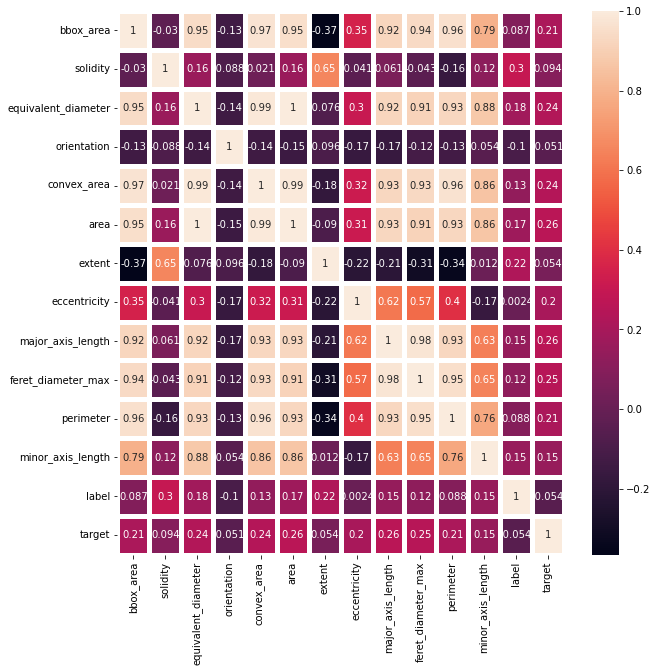

In [25]:
_, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corrmat, linewidths=5, annot=True);

In [26]:
corrmat[corrmat.target > 0].target

bbox_area              0.210387
solidity               0.093737
equivalent_diameter    0.236483
convex_area            0.239025
area                   0.259109
extent                 0.053506
eccentricity           0.200212
major_axis_length      0.261621
feret_diameter_max     0.249292
perimeter              0.211087
minor_axis_length      0.149865
target                 1.000000
Name: target, dtype: float64

In [27]:
features_names = list(dict(corrmat[corrmat.target >= 0].target).keys())

X = features_labeling[features_names].drop(labels=['target'], axis=1)
y = features_labeling.target

X_train, X_test, y_train, y_test = train_test_split(X.values, 
                                                    y.values, 
                                                    test_size=0.2,
                                                    random_state=0)

scaler = StandardScaler()

scaled_x_train = scaler.fit_transform(X_train)
scaled_x_test = scaler.transform(X_test)

In [28]:
features_names

['bbox_area',
 'solidity',
 'equivalent_diameter',
 'convex_area',
 'area',
 'extent',
 'eccentricity',
 'major_axis_length',
 'feret_diameter_max',
 'perimeter',
 'minor_axis_length',
 'target']

In [34]:
run_all_regressions(scaled_x_train, 
                    scaled_x_test,
                    y_train,
                    y_test,
                    regs = {
                        "rf":RandomForestRegressor(),
                        "Lasso": Lasso(), 
                        "LinearRegression": LinearRegression(),
                        "Ridge": Ridge(),
                        "BayesianRidge": BayesianRidge(), 
                        "ElasticNet": ElasticNet(), 
                        "SGDRegressor": SGDRegressor()
                    })


-----rf------
[Train] -------------
MAE: 109.21812500000001
MSE: 16589.365836249995
RMSE: 128.799712096922
R2 Square 0.8199486765057062
[Test] --------------
MAE: 183.696
MSE: 71578.05438000002
RMSE: 267.54075274619385
R2 Square 0.09804049225292977

-----Lasso------
[Train] -------------
MAE: 240.3980208129705
MSE: 80119.18260880196
RMSE: 283.0533211407384
R2 Square 0.1304330130285033
[Test] --------------
MAE: 159.56188281155414
MSE: 59030.1996666206
RMSE: 242.96131310688253
R2 Square 0.2561567886316669

-----LinearRegression------
[Train] -------------
MAE: 225.13252319215363
MSE: 71812.38351753028
RMSE: 267.97832658170375
R2 Square 0.22059017666862668
[Test] --------------
MAE: 189.97924367321383
MSE: 63990.5531505526
RMSE: 252.96354114882365
R2 Square 0.19365106637681773

-----Ridge------
[Train] -------------
MAE: 246.59492120806462
MSE: 83891.09888016633
RMSE: 289.63960171248397
R2 Square 0.08949482868363778
[Test] --------------
MAE: 159.69393040756415
MSE: 64267.070320654566
R

## Cross Validation

In [33]:
scaler = StandardScaler()
scaled_x = scaler.fit_transform(X)

model = SGDRegressor()
scores = cross_val_score(model, scaled_x, y, cv=5, scoring='r2')

print("Todos Scores: ", scores)
print("R2 Score Médio: ", np.mean(scores))

Todos Scores:  [-0.43923712 -0.02983968 -0.2105142   0.01922243 -0.19658286]
R2 Score Médio:  -0.17139028693741212
